In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as pl
import time

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from project_utilities import efficiency
from project_utilities import Loss
from project_utilities import ValueSet
from sklearn.model_selection import train_test_split

In [ ]:
random_seed=156
learning_rate=0.01
num_epochs=5
batch_size=256

In [ ]:
class MyDataset(torch.utils.data.Dataset): 
  def __init__(self, setID): 
        'Initialization' 
        npz_files_content = np.load("./drive/MyDrive/data/Set_"+str(setID)+".npz")  
         
        self.X_set = torch.tensor(npz_files_content['X'])    
        self.y_set = torch.tensor(npz_files_content['y']) 
  def __len__(self): 
        'Denotes the total number of samples' 
        return len(self.y_set) 
  def __getitem__(self, index): 
        'Generates one sample of data' 
        # Select sample 
        X = self.X_set[index] 
        y = self.y_set[index] 
        return X, y

In [ ]:
##########################
### MODEL
##########################


class Residual_Net(torch.nn.Module):

    def __init__(self):
        super(Residual_Net, self).__init__()
        
        #########################
        ### 1st residual block
        #########################
        
        self.block_1 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=4,
                                out_channels=8,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                torch.nn.BatchNorm2d(8),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=8,
                                out_channels=4,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                torch.nn.BatchNorm2d(4)
        )
        
        
        #########################
        ### 2nd residual block
        #########################
        
        self.block_2 = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=4,
                                out_channels=8,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                torch.nn.BatchNorm2d(8),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels=8,
                                out_channels=1,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                torch.nn.BatchNorm2d(1)
        )

        
    def forward(self, x):
       
        x=x.view(batch_size,4,1,4000)
        shortcut = x
        x = self.block_1(x)
        x = torch.nn.functional.relu(x + shortcut)
        shortcut = x
        x = self.block_2(x)
        logits = torch.nn.functional.relu(x)
        logits=logits.view(batch_size,4000)
        return logits

    
torch.manual_seed(random_seed)

In [ ]:
def train(model, num_epochs, 
          learning_rate=0.01, seed=156, batch_size=256): 
    cost = [] 
     
    torch.manual_seed(seed) 
     
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
     
    for e in range(1,num_epochs): 
      batch_num = 0 
      for setID in train_set_idx: 
          train_set = MyDataset(setID+1) 
          train_generator = torch.utils.data.DataLoader(train_set,  
                                                        batch_size=batch_size,  
                                                        shuffle=True,  drop_last=True) 
          for X_train, y_train in train_generator: 
            batch_num = batch_num + 1 
            #### Compute outputs #### 
            yhat = model(X_train) 
            loss = loss_model.forward(yhat, y_train) 
            #### Reset gradients from previous iteration #### 
            optimizer.zero_grad() 
             
            #### Compute gradients #### 
            loss.backward() 
             
            #### Update weights #### 
            optimizer.step() 
            #### Logging #### 
            with torch.no_grad(): 
                yhat = model.forward(X_train) 
                curr_loss = loss_model.forward(yhat, y_train) 
                cost.append(curr_loss) 
    return cost

In [ ]:
def validate(model): 
    loss_val = [] 
    eff = ValueSet(0, 0, 0, 0) 
    # switch to evaluate mode 
    model.eval() 
    with torch.no_grad():
        for setID in val_set_idx: 
          val_set = MyDataset(setID+1) 
          val_generator = torch.utils.data.DataLoader(val_set,  
                                                      batch_size=5000,  
                                                      shuffle=True,  drop_last=True) 
          for X_val, y_val in val_generator:
            # Forward pass 
            val_outputs = model(X_val) 
            loss_output = loss_model.forward(val_outputs, y_val) 
            loss_val.append(loss_output) 
            for label, output in zip(y_val.cpu().numpy(), val_outputs.cpu().numpy()):
                eff += efficiency(label, output, difference = 5.0,  
                                  threshold = 1e-2, integral_threshold = 0.2,  
                                  min_width = 3) 
    return sum(loss_val)/len(loss_val), eff.eff_rate, eff.fp_rate

In [ ]:
samp_dim=[10, 20, 25, 35, 45]
batch_size=5000
val_loss=[]
tr_loss=[]
params=[]
c_list=[]
for val in range(len(samp_dim)):
    model = Residual_Net()  
    loss_model = Loss(0.00001)
    batch_size=256
    train_set_idx, val_set_idx = train_test_split(list(range(1,80)), test_size=samp_dim[val])
    c_list=train(model, num_epochs=5, seed=random_seed, batch_size=256)
    tr_loss.append(float(c_list[-1]))
    batch_size=5000
    loss_val, eff_rate, fp_rate = validate(model)
    print('Training Loss for Sample size : %d ' % samp_dim[val],'is: %0.5f ' % float(c_list[-1]))
    print('Validation Loss for Sample size : %d' % samp_dim[val],'is: %0.5f ' % float(loss_val))
    val_loss.append(float(loss_val))   

Training Loss for Sample size : 10  is: 0.06533 
Validation Loss for Sample size : 10 is: 0.06735 
Training Loss for Sample size : 20  is: 0.05514 
Validation Loss for Sample size : 20 is: 0.05592 
Training Loss for Sample size : 25  is: 0.09583 
Validation Loss for Sample size : 25 is: 0.09574 
Training Loss for Sample size : 35  is: 0.07371 
Validation Loss for Sample size : 35 is: 0.07326 
Training Loss for Sample size : 45  is: 0.07178 
Validation Loss for Sample size : 45 is: 0.07090 


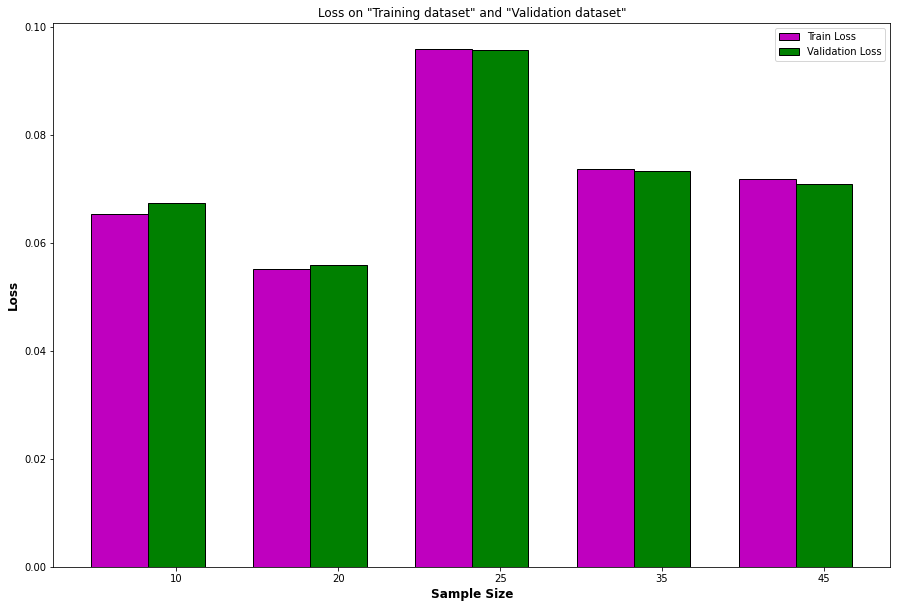

In [ ]:
brWid=0.35
fig = pl.subplots(figsize =(15,10))
b1 = np.arange(5)
b2 = [val + brWid for val in b1]

pl.bar(b1, tr_loss, color ='m', width = brWid,
        edgecolor ='black', label ='Train Loss')
pl.bar(b2, val_loss, color ='g', width = brWid,
        edgecolor ='black', label ='Validation Loss')

pl.title('Loss on "Training dataset" and "Validation dataset"')
pl.xlabel('Sample Size', fontweight ='bold', fontsize = 12)
pl.ylabel('Loss', fontweight ='bold', fontsize = 12)
pl.xticks([ival + brWid for ival in range(5)],
        ['10', '20', '25', '35', '45'])
pl.legend()
pl.show()


In [ ]:
c_list=[]
model = Residual_Net()  
loss_model = Loss(0.00001)
batch_size=256
train_set_idx, val_set_idx = train_test_split(list(range(1,80)), test_size=20)
c_list=train(model, num_epochs=15, seed=random_seed, batch_size=256)
batch_size=5000
loss_val, eff_rate, fp_rate = validate(model)
print('Training Loss is: %0.5f ' % float(c_list[-1]))
print('Validation Loss is: %0.5f ' % float(loss_val)) 

Training Loss is: 0.09669 
Validation Loss is: 0.09578 


In [ ]:
c_list=[]
model = Residual_Net()  
loss_model = Loss(0.00001)
batch_size=256
train_set_idx, val_set_idx = train_test_split(list(range(1,80)), test_size=10)
c_list=train(model, num_epochs=15, seed=random_seed, batch_size=256)
batch_size=5000
loss_val, eff_rate, fp_rate = validate(model)
print('Training Loss is: %0.5f ' % float(c_list[-1]))
print('Validation Loss is: %0.5f ' % float(loss_val))
torch.save(model.state_dict(),'Parameters.pt')    

Training Loss is: 0.05325 
Validation Loss is: 0.05660 


In [ ]:
# For loading the weights
model.load_state_dict(torch.load('Parameters.pt'))